Data saved in: Output\HourlyModelOutput(Kg).csv 
Perform Monte Carlo simulation?[y/n]
Y
Please enter the error threshold without the percent symbol (e.g: 20 for 20%).
0
Please enter the amount of simulations you would like the Monte Carlo to do.
1
The Monte Carlo figures are complete and have been generated in "Output/Monte_Carlo_Graphs"


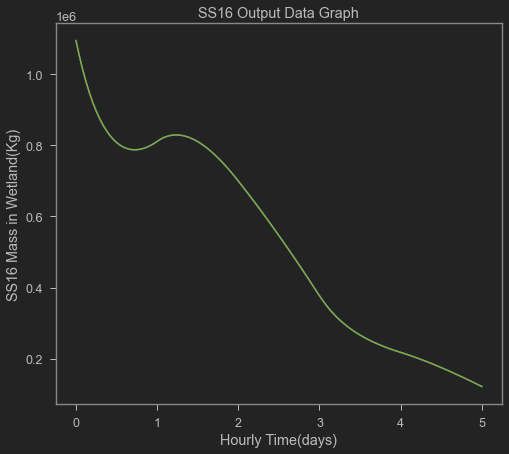

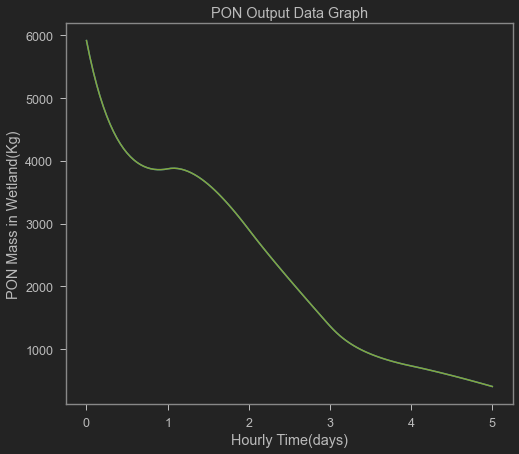

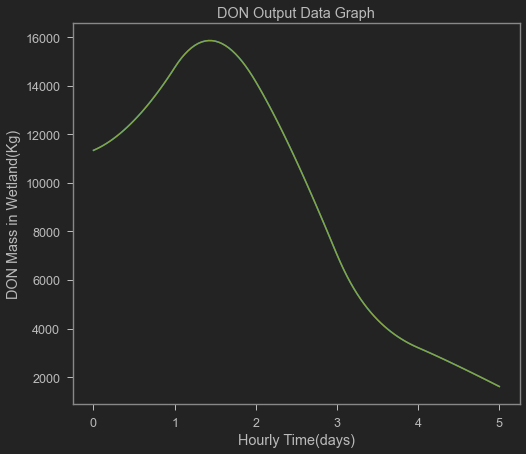

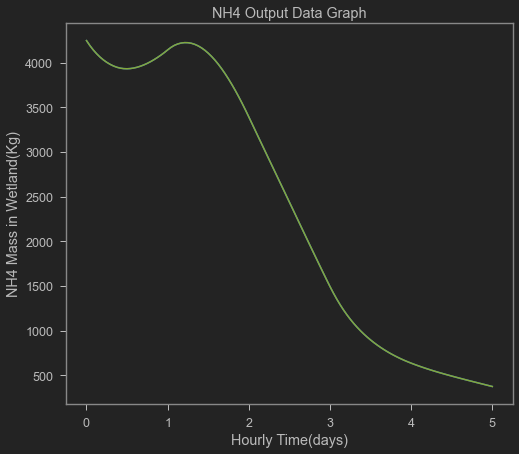

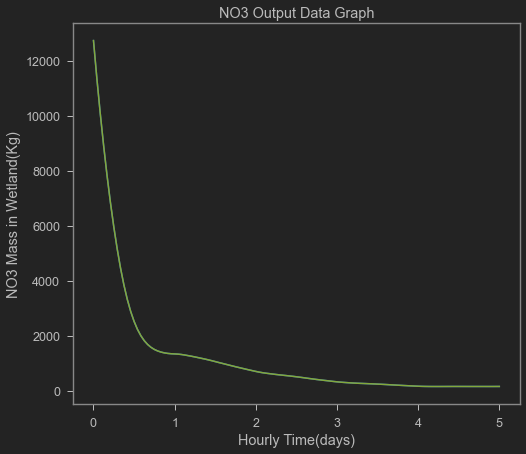

In [3]:
###########################################################################################################################################################################################
#                                                             Trimester 1/3900ESC:WIL2020/Griffith University
#                                                               Nitrogen Cycle in Wetlands ODE Model Solver
#                                                                    Author: Hashim Mohamed (s5052848) 
#                                                                     Supervisor: Dr Melanie Roberts
###########################################################################################################################################################################################
# This is python script solves a system of ODEs labeled as equations 8, 10, 11, 12, 13 in the article "Tropical Coastal Wetlands Ameliorate Nitrogen Export During Floods"[1].
# The output is in the form of numerical data representing the mass of the seperate N-forms(SS16,PON,DON,NO3,NH4) in a wetland.(Saved as HourlyModelOutput(Kg).csv in Output\Model Output)
# Additionally, there are graphs representing the amount of each N-form from hour to hour  
# An optional Monte Carlo simulation can also be done for each of the N-forms.
###########################################################################################################################################################################################
# [1]	M.F. Adame, M.E. Roberts, D.P. Hamilton, C.E. Ndehedehe, V. Reis, J. Lu, M. Griffiths, G. Curwen and M. Ronan,
#      “Tropical Coastal Wetlands Ameliorate Nitrogen Export During Floods,” in Frontiers in Marine Science.
#      Frontiers in Marine Science, [online document], 2019. Available: Frontiers in Marine Science Online,
#      https://www.frontiersin.org/articles/10.3389/fmars.2019.00671/full [Accessed: May 24,2007].
###########################################################################################################################################################################################

############################################################################ Python Modules Imported ######################################################################################
#These are the modules needed to run this code. If the code is not running doble check these are installed
from scipy.interpolate import interp1d# Interpolation module
import pandas as pd                   # Module used to import data (This will import data from given csv files here)
from scipy.integrate import solve_ivp # solve_ivp from scipy module will solve the odes
from numpy import *
import numpy as np                    # Numpy will be used for math
from matplotlib import pyplot as plt  # Plotting results from answers
from random import randrange, uniform 
from pathlib import Path # to support relative paths on both windows and mac 
#import time #Re-enable this if you wish to time the code(debuging purposes) 
###########################################################################################################################################################################################
# used to time the code for debugging purposes.
#start_time = time.time() #time the code(debuging purposes) 
#read the csv data files in a file called "Input" by just passing the path of the input files to the read_csv function
input_folder = Path("Input/")  #see https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f
data = pd.read_csv (input_folder / "Daily_Volume&Area.csv") #Gives daily Surface Area and Volume readings with respect to the time in days
data2 = pd.read_csv (input_folder /  "Hourly_Watertemp(C).csv") #Gives hourly Mean water temperature readings with respect to the time in days
data3 = pd.read_csv (input_folder / "Daily_InfluxData.csv") #Gives daily nitrogen influx data readings with respect to the time in days
data4 = pd.read_csv (input_folder / "Hourly_Rainfall(mm).csv") #Gives hourly rainfall data readings with respect to the time in days
data5 = pd.read_csv (input_folder / "Daily_EvaporationRates(mm).csv") #Gives daily evaporation rate data readings with respect to the time in days

# The data taken before using "read_csv" is stored in df(data frame) as arrays(lists) !!!!!df is a list of lists!!!!
#df's "Time (days)" is in days (e.g day 1,2,3,4...) but df2's "time in days" is in hours (e.g day 1, 1.041, 1.083...) 

#Millimeter evaporation and rainfall values are taken in and then converted to meters when used
df = pd.DataFrame(data, columns= ['Time (days)','Volume (m^3)','SurfaceArea (m^2)']) # From Daily_Volume&Area.csv !!Needs interpolation!!
df2 = pd.DataFrame(data2, columns= ['Time (days)','Water Temp [C]']) # From Hourly_Watertemp(C).csv 
df3 = pd.DataFrame(data3, columns= ['Time (days)','Qin(m^3/s)','NO3in (Kg/day)','NH4in (Kg/day)','DONin (Kg/day)','PONin (Kg/day)','SS16in (Kg/day)']) # From Daily_InfluxData.csv !!Needs interpolation!!
df4 = pd.DataFrame(data4, columns= ['Time (days)','Rainfall (mm)']) # From Hourly_Rainfall(mm).csv. 
df5 = pd.DataFrame(data5, columns= ['Time (days)','Evaporation (mm)']) # From Daily_EvaporationRates(mm).csv !!Needs interpolation!!

########################################################################################
#These values will not change. They remain constant no matter what the data entered is.
########################################################################################
# Units: mass - kilograms, time - days, length - metres, temperature - celsius

theta = 1.073 # [no unit]

k1 = 0.2  # [1/day]

a1 = 0.025e-3 # Or 0.007e-3 #[Kg/m^2 day] % range 0.004 -  0.05.  From Fern's data 0.007

a2 = 1.24e-3 # Or 1.14e-3 #[Kg/m^2 day] Fern's data

k2 = 0.01 # [1/day] range 0.001 - 0.028

a5 = 0.03e-3 # Or 0.08e-3 #[Kg/m^2 day] range 0.03 - 0.33 estimated value.  

# k6 = 0 # this was for the annamox that has been removed

a6 = 0.00005e-3 # Or 0.01e-3 #[Kg/m^2 day] 

k4 = 0.1 #[1/day]

a4 = 0.0075e-3 # Or 0.02e-3 # [Kg/m^2 day] range 0.01 - 0.11.  

k3 = 3e-4 # [1/day]

a3 = 0.0336e-3 # [Kg/m^2 day] TBC

K1 = 0.01e-3 #[Kg/m^3]

KN = 0.01e-3 #[Kg/m^3] % range 0.01 - 0.05 [mg/L]

Ka2 = 0.1e-3  # [Kg/m^3]     

K2  = 0.01e-3 #[Kg/m^3]

K4  = 0.05e-3 # [Kg/m^3]

K3  = 2e-3 # [Kg/m^3]

Ka3 = 0.1e-3 # [Kg/m^3]

NO3Crain = 1.1e-9 # [Kg/m^3]

NH4Crain = 3.2e-9 # [Kg/m^3]
###############################################################
# Variables that need to be calculated. 
###############################################################
#To find sediment settling rate (Ws), stokes law is used
#The following parameters are used:

sediment_diameter = 3e-6 #[m]

dynamicViscosity = 0.0010016 #[kg/ms]

sediment_density = 1300 #[kg/m^3]

gravity = 9.8 # m/s^2

fluid_density = 997 #[kg/m^3]

#Parameters above are put in the equation below:
mksSettling = (sediment_density - fluid_density)*gravity*sediment_diameter**2/(18*dynamicViscosity)# (** = ^) in python

#Settling Rate (Ws):
Ws = mksSettling*60*60*24 # [m/day] (density of organic clay from https://structx.com/Soil_Properties_002.html)
WsPON = mksSettling*60*60*24 # [m/day]

#Qout calculation
Qout_list = []
# daily values for the volume difference are calculated and the volume difference on  the first is zero.
Vdiff = np.diff(df['Volume (m^3)'])
Vdiff = np.insert(Vdiff,0,0.0,axis = 0) 
i=0
#Using values imported from the input files (Qin,Rainfall,Surface and evaporation) as well as the volume diference,
#Daily vales for Qout are found.
while(i<(len(df['Time (days)']))):
    Qout_val = ((df3['Qin(m^3/s)'][i])*60*60*24) - Vdiff[i] + (((df4['Rainfall (mm)'][i*24])/1000)*(df['SurfaceArea (m^2)'][i])) - (((df5['Evaporation (mm)'][i])/1000)*(df['SurfaceArea (m^2)'][i]))
    Qout_list.append(Qout_val)
    i+=1
############################################################################################################################
#The interpolation process
############################################################################################################################
def interpolater(T, Y, t):
    f = interp1d(T, Y)
    return f(t) #evaluates Y(T = t)
 
############################################################################################################################
#ODE is solved here
############################################################################################################################
def ODE_Sys(t,S):
    #Values interpolated
    Qin = interpolater(df3['Time (days)'],((df3['Qin(m^3/s)'])*60*60*24),t) #[Qin is imported and interpolated and converted from m^3/s to m^3/day]
    PONCin = interpolater(df3['Time (days)'],df3['PONin (Kg/day)'],t)
    DONCin = interpolater(df3['Time (days)'],df3['DONin (Kg/day)'],t)
    NH4Cin = interpolater(df3['Time (days)'],df3['NH4in (Kg/day)'],t)
    NO3Cin = interpolater(df3['Time (days)'],df3['NO3in (Kg/day)'],t)
    SS16Cin = interpolater(df3['Time (days)'],df3['SS16in (Kg/day)'],t) 
    V = interpolater(df['Time (days)'],df['Volume (m^3)'],t)
    T = interpolater(df2['Time (days)'],df2['Water Temp [C]'],t)
    R = interpolater(df4['Time (days)'],(df4['Rainfall (mm)']/1000),t)
    SA = interpolater(df['Time (days)'],df['SurfaceArea (m^2)'],t)
    Evap = interpolater(df5['Time (days)'],(df5['Evaporation (mm)']/1000),t)
    Qout = interpolater(df['Time (days)'],Qout_list,t)# [m^3/day]
    #Zav(The depth of the wetland) is solved for.
    Zav = V/SA # [m]
    #The ODE system
    SS16,PON,DON,NH4,NO3 = S
    fN = ((NH4*NO3)/((NH4 + (V*KN))*(NO3 + (V*KN))))+((NH4*V*KN)/((NH4 + NO3)*(NO3 + (V*KN)))) # eq-9
    fSS16 = (SS16Cin) - (Qout*(SS16/V)) - ((np.exp((-Ws*t)/Zav))*SS16) # eq-13
    fPON = (PONCin) - (Qout*(PON/V)) + (a6*(theta**(T-20))*SA) - ((k4*(theta**(T-20))*PON)*((PON/V)/((PON/V)+K4))) - ((np.exp((-WsPON*t)/Zav))*PON)# eq-12
    fDON = (DONCin) - (Qout*(DON/V)) - (k2*(theta**(T-20))*DON*((DON/V)/((DON/V)+K2))) + (a5*(theta**(T-20))*SA) + (k4*(theta**(T-20))*PON*((PON/V)/((PON/V)+K4))) # eq-11
    fNH4 = (NH4Cin) - (Qout*(NH4/V)) + (SA*R*NH4Crain) - (k1*(theta**(T-20))*NH4*((NH4/V)/((NH4/V)+K1))) - (a1*(theta**(T-20))*SA*fN) + (k2*(theta**(T-20))*DON*((DON/V)/((DON/V)+K2))) + (a4*(theta**(T-20))*SA) + (k3*(theta**(T-20))*SS16*((SS16/V)/((SS16/V)+K3))) - ((a3/2)*(theta**(T-20))*SA*(((min(NO3,NH4))/V)/(Ka3 + ((min(NO3,NH4))/V)))) # eq-9
    fNO3 = (NO3Cin) - (Qout*(NO3/V)) + (SA*R*NO3Crain) + (k1*(theta**(T-20))*NH4*((NH4/V)/((NH4/V)+K1))) - (a1*(theta**(T-20))*SA*(1-fN)) - (a2*(theta**(T-20))*SA*((NO3/V)/((NO3/V)+Ka2))) - ((a3/2)*(theta**(T-20))*SA*(((min(NO3,NH4))/V)/(Ka3 + ((min(NO3,NH4))/V)))) # eq-8
    return fSS16, fPON, fDON, fNH4, fNO3

#Initial values for the forms of N in the wetland are calculated.
SS16init = (df['Volume (m^3)'][0])*((df3['SS16in (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
PONinit = (df['Volume (m^3)'][0])*((df3['PONin (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
DONinit = (df['Volume (m^3)'][0])*((df3['DONin (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
NO3init = (df['Volume (m^3)'][0])*((df3['NO3in (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
NH4init = (df['Volume (m^3)'][0])*((df3['NH4in (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))

rectime = [] # creates a time array/list
rectime = df['Time (days)'] # time array/list reads how many days have been recorded
start = rectime[0] # what was the first day data was recorded on
end = rectime[(len(rectime)-1)] # what was the last day the data was recorded on
intervals = (end*24)+1 # This finds the amount of hourly intervals in between the days   

#ODE solver solves for amount of the N forms in the wetland at a given hour using initial values
Sol_ODE_Sys = solve_ivp(ODE_Sys,(start,end),(SS16init,PONinit,DONinit,NH4init,NO3init), t_eval = np.linspace(start,end,intervals))

#Lists/arrays made to hold the hourly output from the solver and the corresponding time
SS16sol = []
PONsol = []
DONsol = []
NH4sol = []
NO3sol = [] 
Sol_times = []

#The raw data coming out of the model stored in lists/arrays
Sol_times = Sol_ODE_Sys.t # hourly times model is evaluated at
SS16sol = Sol_ODE_Sys.y[0]# The mass of SS16 in the wetland
PONsol = Sol_ODE_Sys.y[1]# The mass of PON in the wetland
DONsol = Sol_ODE_Sys.y[2]# The mass of DON in the wetland
NH4sol = Sol_ODE_Sys.y[3]# The mass of NO3 in the wetland
NO3sol = Sol_ODE_Sys.y[4]# The mass of NH4 in the wetland

############################################################################################################################
#Output is produced in output file as csv
############################################################################################################################

#These two lines save the lists/arrays as data frames and then exports them to a .csv output file
df6 = pd.DataFrame(data={"Hourly Time (days)": Sol_times,"SS16": SS16sol, "PON": PONsol, "Don": DONsol, "NO3": NO3sol, "NH4": NH4sol})
output_folder = Path("Output/")  # to handle file paths on windows and mac
df6.to_csv(output_folder / "HourlyModelOutput(Kg).csv",sep=',',index=False) 


print("Data saved in: Output\HourlyModelOutput(Kg).csv ")
print("Perform Monte Carlo simulation?[y/n]")
user_input = input()#Poll the user to see if they want a Monte Carlo

# This is here in case the code is run via cmd.(in cmd no indication is given when the code finishes executing)
if(user_input != 'y') and (user_input != 'Y'):
	print("ODE model complete.Monte Carlo simulation not done.")

###################################################################
#Plots to insure data matches expected shapes(debugging purposes)
###################################################################
###################!You can achieve this result by making the uncertainty in the monte carlo 0 percent and run 1 simulation!##############

#plt.figure(5)
#plt.plot(Sol_times,SS16sol)
#plt.savefig(output_folder / "SS16.png") # save as png
#plt.figure(6)
#plt.plot(Sol_times,PONsol)
#plt.savefig(output_folder / "PON.png") # save as png
#plt.figure(7)
#plt.plot(Sol_times,DONsol)
#plt.savefig(output_folder / "DON.png")# save as png
#plt.figure(8)
#plt.plot(Sol_times,NH4sol)
#plt.savefig(output_folder / "NH4.png") # save as png
#plt.figure(9)
#plt.plot(Sol_times,NO3sol)
#plt.savefig(output_folder / "NO3.png")# save as png

if (user_input == 'y') or (user_input == 'Y') :
############################################################################################################################
#Monte Carlo starts here.
############################################################################################################################
    #Poll the user for the percentage error range they want.
    print("Please enter the error threshold without the percent symbol (e.g: 20 for 20%).")
    user_input = float(input())
    disperror = user_input # used later to display the error chosen by the user on the Monte Carlo plots.
    error = ((user_input)/100) #error 
    #Poll the user for the amount of simulations they would like to be included
    print("Please enter the amount of simulations you would like the Monte Carlo to do.")
    number_of_sims = int(input())
    m=0 # step index
    # This is here in case the code is run via cmd.(in cmd no indication is given when the code finishes executing)        
    print('The Monte Carlo figures are complete and have been generated in "Output/Monte_Carlo_Graphs"')   
    while(m<=number_of_sims) :

# Error is added to the "k" and "a" values. The maximum error is decided by the "error" value
# None of these values share the same amount of error
        k1error = uniform((k1*(1-error)), (k1*(1+error)))  # [1/day]0.2
        #print(k1error)
        a1error = uniform((a1*(1-error)), (a1*(1+error))) # [Kg/m^2 day] From Fern's data 0.007
        #print(a1error)
        a2error = uniform((a2*(1-error)), (a2*(1+error))) # [Kg/m^2 day] Fern's data
        #print(a2error)
        k2error = uniform((k2*(1-error)), (k2*(1+error))) # [1/day] 
        #print(k2error)
        a5error = uniform((a5*(1-error)), (a5*(1+error))) #[Kg/m^2 day]   
        #print(a5error)
        # k6error = uniform((k6*(1-error)), (k6*(1+error))) # this was for the annamox that has been removed
        #print(k6error)
        a6error = uniform((a6*(1-error)), (a6*(1+error)))  #[Kg/m^2 day] 
        #print(a6error)
        k4error = uniform((k4*(1-error)), (k4*(1+error))) #[1/day]
        #print(k4error)
        a4error = uniform((a4*(1-error)), (a4*(1+error))) # [Kg/m^2 day] 
        #print(a4error)
        k3error = uniform((k3*(1-error)), (k3*(1+error))) # [1/day]
        #print(k3error)
        a3error = uniform((a3*(1-error)), (a3*(1+error))) # [Kg/m^2 day] TBC
        #print(a3error)
        K1error = uniform((K1*(1-error)), (K1*(1+error))) #[Kg/m^3]
        #print(K1error)
        KNerror = uniform((KN*(1-error)), (KN*(1+error))) #[Kg/m^3] 
        #print(KNerror)
        Ka2error = uniform((Ka2*(1-error)), (Ka2*(1+error)))  # [Kg/m^3]     
        #print(Ka2error)
        K2error  = uniform((K2*(1-error)), (K2*(1+error))) #[Kg/m^3]
        #print(K2error)
        K4error  = uniform((K4*(1-error)), (K4*(1+error))) # [Kg/m^3]
        #print(K4error)
        K3error  = uniform((K3*(1-error)), (K3*(1+error))) # [Kg/m^3]
        #print(K3error)
        Ka3error = uniform((Ka3*(1-error)), (Ka3*(1+error))) # [Kg/m^3]
        #print(Ka3error)
    

#ODE Modified for Monte Carlo    
        def ODE_Sys(t,S):
        #Values interpolated
            Qin = interpolater(df3['Time (days)'],((df3['Qin(m^3/s)'])*60*60*24),t) #[Qin is imported and interpolated and converted from m^3/s to m^3/day]
            PONCin = interpolater(df3['Time (days)'],df3['PONin (Kg/day)'],t)
            DONCin = interpolater(df3['Time (days)'],df3['DONin (Kg/day)'],t)
            NH4Cin = interpolater(df3['Time (days)'],df3['NH4in (Kg/day)'],t)
            NO3Cin = interpolater(df3['Time (days)'],df3['NO3in (Kg/day)'],t)
            SS16Cin = interpolater(df3['Time (days)'],df3['SS16in (Kg/day)'],t) 
            V = interpolater(df['Time (days)'],df['Volume (m^3)'],t)
            T = interpolater(df2['Time (days)'],df2['Water Temp [C]'],t)
            R = interpolater(df4['Time (days)'],(df4['Rainfall (mm)']/1000),t)
            SA = interpolater(df['Time (days)'],df['SurfaceArea (m^2)'],t)
            Evap = interpolater(df5['Time (days)'],(df5['Evaporation (mm)']/1000),t)
            Qout = interpolater(df['Time (days)'],Qout_list,t)# [m^3/day]
            #Zav(The depth of the wetland) is solved for.
            Zav = V/SA # [m]
            #The ODE system
            SS16,PON,DON,NH4,NO3 = S
            fN = ((NH4*NO3)/((NH4 + (V*KNerror))*(NO3 + (V*KNerror))))+((NH4*V*KNerror)/((NH4 + NO3)*(NO3 + (V*KNerror)))) # eq-9
            fSS16 = (SS16Cin) - (Qout*(SS16/V)) - ((np.exp((-Ws*t)/Zav))*SS16) # eq-13
            fPON = (PONCin) - (Qout*(PON/V)) + (a6error*(theta**(T-20))*SA) - ((k4error*(theta**(T-20))*PON)*((PON/V)/((PON/V)+K4error))) - ((np.exp((-WsPON*t)/Zav))*PON)# eq-12
            fDON = (DONCin) - (Qout*(DON/V)) - (k2error*(theta**(T-20))*DON*((DON/V)/((DON/V)+K2error))) + (a5error*(theta**(T-20))*SA) + (k4error*(theta**(T-20))*PON*((PON/V)/((PON/V)+K4error))) # eq-11
            fNH4 = (NH4Cin) - (Qout*(NH4/V)) + (SA*R*NH4Crain) - (k1error*(theta**(T-20))*NH4*((NH4/V)/((NH4/V)+K1error))) - (a1error*(theta**(T-20))*SA*fN) + (k2error*(theta**(T-20))*DON*((DON/V)/((DON/V)+K2error))) + (a4error*(theta**(T-20))*SA) + (k3error*(theta**(T-20))*SS16*((SS16/V)/((SS16/V)+K3error))) - ((a3error/2)*(theta**(T-20))*SA*(((min(NO3,NH4))/V)/(Ka3error +((min(NO3,NH4))/V)))) # eq-9
            fNO3 = (NO3Cin) - (Qout*(NO3/V)) + (SA*R*NO3Crain) + (k1error*(theta**(T-20))*NH4*((NH4/V)/((NH4/V)+K1error))) - (a1error*(theta**(T-20))*SA*(1-fN)) - (a2error*(theta**(T-20))*SA*((NO3/V)/((NO3/V)+Ka2error))) - ((a3error/2)*(theta**(T-20))*SA*(((min(NO3,NH4))/V)/(Ka3error + ((min(NO3,NH4))/V)))) # eq-8
            return fSS16, fPON, fDON, fNH4, fNO3
    
#Initial values for the forms of N in the wetland are calculated.
        SS16init = (df['Volume (m^3)'][0])*((df3['SS16in (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
        PONinit = (df['Volume (m^3)'][0])*((df3['PONin (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
        DONinit = (df['Volume (m^3)'][0])*((df3['DONin (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
        NO3init = (df['Volume (m^3)'][0])*((df3['NO3in (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))
        NH4init = (df['Volume (m^3)'][0])*((df3['NH4in (Kg/day)'][0])/((df3['Qin(m^3/s)'][0])*60*60*24))

        rectime = [] # creates a time array/list
        rectime = df['Time (days)'] # time array/list reads how many days have been recorded
        start = rectime[0] # what was the first day data was recorded on
        end = rectime[(len(rectime)-1)] # what was the last day the data was recorded on
        intervals = (end*24)+1 # This finds the amount of hourly intervals in between the days   

#ODE solver solves for amount of the N forms in the wetland at a given hour using initial values
        Sol_ODE_Sys = solve_ivp(ODE_Sys,(start,end),(SS16init,PONinit,DONinit,NH4init,NO3init), t_eval = np.linspace(start,end,intervals))

#Lists/arrays made to hold the hourly output from the solver and the corresponding time
        SS16sol = []
        PONsol = []
        DONsol = []
        NH4sol = []
        NO3sol = [] 
        Sol_times = []

#The raw data coming out of the model stored in lists/arrays
        Sol_times = Sol_ODE_Sys.t # hourly times model is evaluated at
        SS16sol = Sol_ODE_Sys.y[0]# The mass of SS16 in the wetland
        PONsol = Sol_ODE_Sys.y[1]# The mass of PON in the wetland
        DONsol = Sol_ODE_Sys.y[2]# The mass of DON in the wetland
        NH4sol = Sol_ODE_Sys.y[3]# The mass of NO3 in the wetland
        NO3sol = Sol_ODE_Sys.y[4]# The mass of NH4 in the wetland
################################################################
#Monte Carlo output
################################################################
#The if statements ensure the figures are saved only after the last loop in this while loop 
        
        #Plots, labels and saves a figure of the Monte Carlo for SS16
        mcplot_folder = Path("Output/Monte_Carlo_Graphs/")
        plt.figure(0)
        plt.plot(Sol_times,SS16sol)
        if (m==number_of_sims) and (number_of_sims>1):
            plt.title('SS16 Monte Carlo For '+str(number_of_sims)+' Simulations With Error Limit at '+str(disperror)+'%')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('SS16 Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "SS16_Monte_Carlo.png")  
        elif (m==1) and (error==0):
            plt.title('SS16 Output Data Graph')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('SS16 Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "SS16 Output Data Graph.png")
        #Plots, labels and saves a figure of the Monte Carlo for PON    
        plt.figure(1)
        plt.plot(Sol_times,PONsol)
        if (m==number_of_sims) and (number_of_sims>1):
            plt.title('PON Monte Carlo For '+str(number_of_sims)+' Simulations With Error Limit at '+str(disperror)+'%')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('PON Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder /"PON_Monte_Carlo.png") 
        elif (m==1) and (error==0):
            plt.title('PON Output Data Graph')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('PON Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "PON Output Data Graph.png")
        #Plots, labels and saves a figure of the Monte Carlo for DON    
        plt.figure(2)
        plt.plot(Sol_times,DONsol)
        if (m==number_of_sims) and (number_of_sims>1):
            plt.title('DON Monte Carlo For '+str(number_of_sims)+' Simulations With Error Limit at '+str(disperror)+'%')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('DON Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "DON_Monte_Carlo.png") 
        elif (m==1) and (error==0):
            plt.title('DON Output Data Graph')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('DON Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "DON Output Data Graph.png")
        #Plots, labels and saves a figure of the Monte Carlo for NH4    
        plt.figure(3)
        plt.plot(Sol_times,NH4sol)
        if (m==number_of_sims) and (number_of_sims>1):
            plt.title('NH4 Monte Carlo For '+str(number_of_sims)+' Simulations With Error Limit at '+str(disperror)+'%')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('NH4 Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "NH4_Monte_Carlo.png") 
        elif (m==1) and (error==0):
            plt.title('NH4 Output Data Graph')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('NH4 Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "NH4 Output Data Graph.png")
        #Plots, labels and saves a figure of the Monte Carlo for NO3    
        plt.figure(4)
        plt.plot(Sol_times,NO3sol)
        if (m==number_of_sims) and (number_of_sims>1):
            plt.title('NO3 Monte Carlo For '+str(number_of_sims)+' Simulations With Error Limit at '+str(disperror)+'%')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('NO3 Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "NO3_Monte_Carlo.png") 
        elif (m==1) and (error==0):
            plt.title('NO3 Output Data Graph')
            plt.xlabel('Hourly Time(days)')
            plt.ylabel('NO3 Mass in Wetland(Kg)')
            plt.savefig(mcplot_folder / "NO3 Output Data Graph.png")
        m+=1

################################################################
#Timer(debugging purposes)
################################################################
#print("--- %s seconds ---" % (time.time() - start_time))